<a href="https://colab.research.google.com/github/ljs7463/AnalysisProject/blob/master/%EB%8D%B0%EC%9D%B4%EC%BD%98/analytics/stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')


# 데이터 로드
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')

In [24]:

x_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
y_train = pd.DataFrame(y_train)
x_test = df_test




In [25]:

# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import optuna
from lightgbm import LGBMClassifier,early_stopping
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
column_transformer = ColumnTransformer(
    [
        ('encoder', OneHotEncoder(), ['preferred_difficulty_level', 'subscription_type']),
    ],
    remainder='passthrough'  # 나머지 컬럼은 그대로 유지
)
transformed_data  = column_transformer.fit_transform(x_train)
# 결과를 DataFrame으로 변환 (새로운 컬럼 이름 포함)
new_column_names = column_transformer.get_feature_names_out()
x_train = pd.DataFrame(transformed_data, columns=new_column_names)

transformed_data = column_transformer.transform(x_test)
# 결과를 DataFrame으로 변환 (새로운 컬럼 이름 포함)
new_column_names = column_transformer.get_feature_names_out()
x_test = pd.DataFrame(transformed_data, columns=new_column_names)


# scaler
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
x_train[['remainder__subscription_duration',
      'remainder__recent_login_time',
      'remainder__average_time_per_learning_session',
      'remainder__monthly_active_learning_days',
      'remainder__total_completed_courses',
      'remainder__recent_learning_achievement',
      'remainder__abandoned_learning_sessions',
      'remainder__community_engagement_level',
      'remainder__customer_inquiry_history',
      'remainder__payment_pattern']] = rbs.fit_transform(x_train[['remainder__subscription_duration',
      'remainder__recent_login_time',
      'remainder__average_time_per_learning_session',
      'remainder__monthly_active_learning_days',
      'remainder__total_completed_courses',
      'remainder__recent_learning_achievement',
      'remainder__abandoned_learning_sessions',
      'remainder__community_engagement_level',
      'remainder__customer_inquiry_history',
      'remainder__payment_pattern']]
)

x_test[['remainder__subscription_duration',
      'remainder__recent_login_time',
      'remainder__average_time_per_learning_session',
      'remainder__monthly_active_learning_days',
      'remainder__total_completed_courses',
      'remainder__recent_learning_achievement',
      'remainder__abandoned_learning_sessions',
      'remainder__community_engagement_level',
      'remainder__customer_inquiry_history',
      'remainder__payment_pattern']] = rbs.transform(x_test[['remainder__subscription_duration',
      'remainder__recent_login_time',
      'remainder__average_time_per_learning_session',
      'remainder__monthly_active_learning_days',
      'remainder__total_completed_courses',
      'remainder__recent_learning_achievement',
      'remainder__abandoned_learning_sessions',
      'remainder__community_engagement_level',
      'remainder__customer_inquiry_history',
      'remainder__payment_pattern']]
)



x_train = x_train.drop(columns = 'remainder__user_id')
x_test = x_test.drop(columns = 'remainder__user_id')

x_train[["encoder__preferred_difficulty_level_High","encoder__preferred_difficulty_level_Low","encoder__preferred_difficulty_level_Medium","encoder__subscription_type_Basic","encoder__subscription_type_Premium",'remainder__average_login_time']] = x_train[["encoder__preferred_difficulty_level_High","encoder__preferred_difficulty_level_Low","encoder__preferred_difficulty_level_Medium","encoder__subscription_type_Basic","encoder__subscription_type_Premium",'remainder__average_login_time']].astype(float)
x_test[["encoder__preferred_difficulty_level_High","encoder__preferred_difficulty_level_Low","encoder__preferred_difficulty_level_Medium","encoder__subscription_type_Basic","encoder__subscription_type_Premium",'remainder__average_login_time']] = x_test[["encoder__preferred_difficulty_level_High","encoder__preferred_difficulty_level_Low","encoder__preferred_difficulty_level_Medium","encoder__subscription_type_Basic","encoder__subscription_type_Premium",'remainder__average_login_time']].astype(float)
####################################################################
# 차원축소
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# x_train  = lda.fit_transform(x_train, y_train)
# x_test = lda.transform(x_test)

####################################################################
# feature selection
from sklearn.feature_selection import SelectFromModel

param_grid_lgbm = {
    'num_leaves': [31, 50, 70],  # 하나의 트리가 가질 수 있는 최대 잎의 수
    'learning_rate': [0.01, 0.05, 0.1],  # 학습률
    'n_estimators': [100, 200, 500],  # 부스팅 트리의 수
    'max_depth': [5, 10, 15]  # 트리의 최대 깊이
}
lgbm_model=LGBMClassifier()
# GridSearchCV 객체 생성
grid_search_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)

# GridSearchCV 실행
grid_search_lgbm.fit(x_train, y_train)
# 특성중요도를 기반으로 특성선택
sfm = SelectFromModel(lgbm_model, threshold = 'median')
x_train_transformed = sfm.fit_transform(x_train, y_train)
x_test_transformed = sfm.transform(x_test)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Number of positive: 6199, number of negative: 3801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619900 -> initscore=0.489124
[LightGBM] [Info] Start training from score 0.489124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [26]:
# 선택된 특성의 불리언 마스크를 얻음
selected_features_mask = sfm.get_support()
# 원래 데이터프레임의 컬럼 이름을 사용하여 선택된 특성의 이름을 추출
selected_features = x_train.columns[selected_features_mask]
selected_features

Index(['remainder__subscription_duration', 'remainder__recent_login_time',
       'remainder__average_login_time',
       'remainder__average_time_per_learning_session',
       'remainder__monthly_active_learning_days',
       'remainder__total_completed_courses',
       'remainder__recent_learning_achievement', 'remainder__payment_pattern'],
      dtype='object')

In [27]:
x_train = pd.DataFrame(x_train_transformed,columns = selected_features)
x_test = pd.DataFrame(x_test_transformed, columns = selected_features)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
Best cross-validation score: 0.53


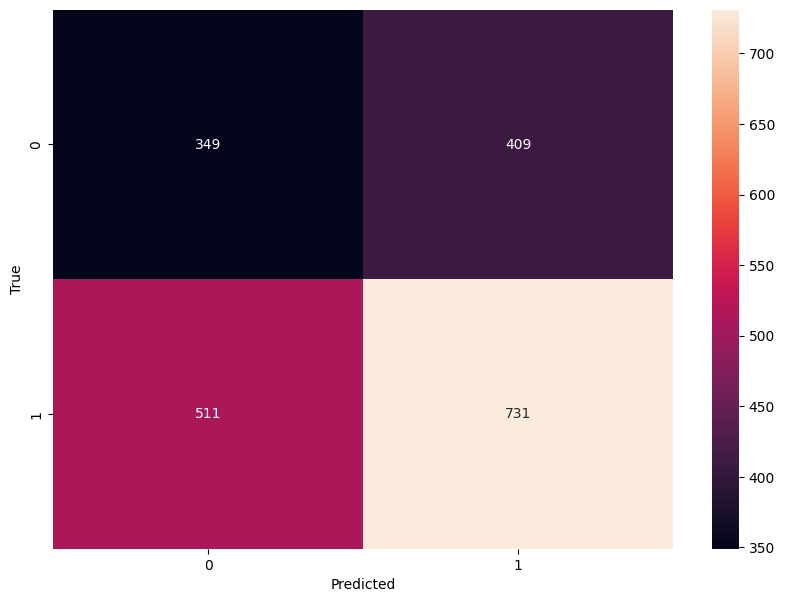

              precision    recall  f1-score   support

           0       0.41      0.46      0.43       758
           1       0.64      0.59      0.61      1242

    accuracy                           0.54      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.55      0.54      0.54      2000



In [28]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# 목적 함수 정의

# 랜덤 시드 고정
np.random.seed(42)


# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

# KNN 모델 생성
knn = KNeighborsClassifier()

# GridSearchCV 객체 생성
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=1)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 파라미터와 점수 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# 최적 파라미터로 모델 학습
best_params = grid_search.best_params_
knn_model = KNeighborsClassifier(**best_params)

knn_model.fit(x_train, y_train)
y_val_pred = knn_model.predict(x_val)
f1_score(y_val, y_val_pred, average = 'macro')


#############################################################################
# 혼동행렬
from sklearn.metrics import confusion_matrix
# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 클래스별 성능 지표 출력
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

In [30]:
knn_y_final_pred = knn_model.predict(x_test)

In [37]:
len(knn_y_final_pred)

10000

In [33]:
knn_y_val_pred = y_val_pred
knn_y_val = y_val
knn_y_final_pred

array([1, 1, 1, ..., 0, 0, 1])

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Best cross-validation score: 0.51


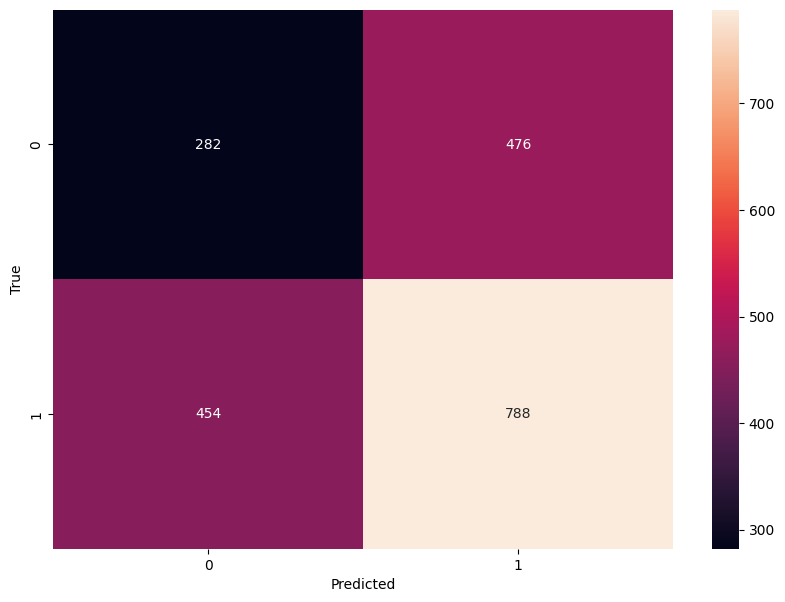

              precision    recall  f1-score   support

           0       0.38      0.37      0.38       758
           1       0.62      0.63      0.63      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



In [34]:


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')


# 데이터 로드
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')


####################################################################

## Label Encoding

## train데이터
df_train['preferred_difficulty_level'] = pd.factorize(df_train['preferred_difficulty_level'])[0]
df_train['subscription_type'] = pd.factorize(df_train['subscription_type'])[0]

## test데이터
df_test['preferred_difficulty_level'] = pd.factorize(df_test['preferred_difficulty_level'])[0]
df_test['subscription_type'] = pd.factorize(df_test['subscription_type'])[0]

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_train[i] = scaler.fit_transform(df_train[i])
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_test[i] = scaler.transform(df_test[i])

# Delete user_id
df_train = df_train.drop(columns = 'user_id')

# split target
x = df_train[list(df_train.columns[:-1])]
y = df_train['target']

# Delete user_id
df_test = df_test.drop(columns = 'user_id')
# split target
new_x = df_test


####################################################################


import optuna
from lightgbm import LGBMClassifier,early_stopping
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


# 목적 함수 정의

# 랜덤 시드 고정
np.random.seed(42)
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def obj_knn(trial,x,y):
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
#     metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

#     model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
#     score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
#     f1_macro = np.mean(score)

#     return f1_macro

# # Optuna 최적화 실행
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# # lambda 함수를 사용하여 x와 y를 objective 함수에 전달
# study.optimize(lambda trial: obj_knn(trial, x_train, y_train), n_trials = 100)


# # 최적 파라미터 출력
# print("Best trial:")
# trial = study.best_trial
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# # 최적 파라미터로 모델 학습
# best_params = study.best_trial.params
# knn_model = KNeighborsClassifier(**best_params)

# knn_model.fit(x_train, y_train)
# y_test_pred = knn_model.predict(x_test)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

# KNN 모델 생성
knn = KNeighborsClassifier()

# GridSearchCV 객체 생성
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=1)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 파라미터와 점수 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# 최적 파라미터로 모델 학습
best_params = grid_search.best_params_
knn_model = KNeighborsClassifier(**best_params)

knn_model.fit(x_train, y_train)
y_test_pred = knn_model.predict(x_test)
f1_score(y_test, y_test_pred, average = 'macro')


#############################################################################
# 혼동행렬
from sklearn.metrics import confusion_matrix
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_test_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 클래스별 성능 지표 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

In [39]:
knn_y_final_pred2 =knn_model.predict(new_x)

In [41]:
knn2_y_test_pred = y_test_pred
knn2_y_test = y_test
knn_y_final_pred2

array([1, 1, 0, ..., 0, 1, 1])

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')

# 코랩 실행시
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')

## Label Encoding

## train데이터
df_train['preferred_difficulty_level'] = pd.factorize(df_train['preferred_difficulty_level'])[0]
df_train['subscription_type'] = pd.factorize(df_train['subscription_type'])[0]

## test데이터
df_test['preferred_difficulty_level'] = pd.factorize(df_test['preferred_difficulty_level'])[0]
df_test['subscription_type'] = pd.factorize(df_test['subscription_type'])[0]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_train[i] = scaler.fit_transform(df_train[i])
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_test[i] = scaler.fit_transform(df_test[i])

  # Delete user_id
df_train = df_train.drop(columns = 'user_id')

# split target
x = df_train[list(df_train.columns[:-1])]
y = df_train['target']

# Delete user_id
df_test = df_test.drop(columns = 'user_id')

# split target
new_x = df_test


#################### 층화추출 ###################


import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

def objective(trial,x,y):
    # Optuna가 탐색할 하이퍼파라미터의 범위 설정
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }

    # k-겹 교차 검증 설정
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_index, test_index in kf.split(x, y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # CatBoost 모델 생성 및 훈련
        model = CatBoostClassifier(**param, verbose=0)
        model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=80)

        # 예측 및 F1 점수 계산
        preds = model.predict(x_test)
        f1 = f1_score(y_test, preds, average='macro')
        f1_scores.append(f1)

    # 평균 F1 점수 반환
    return np.mean(f1_scores)

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
# lambda 함수를 사용하여 X와 y를 objective 함수에 전달
study.optimize(lambda trial: objective(trial, x, y), n_trials=100)

# 최적 하이퍼파라미터 출력
print('Best trial:', study.best_trial.params)

[I 2023-12-10 13:02:33,720] A new study created in memory with name: no-name-a5b0c7b8-1417-4530-8531-859504dc0ee2
[I 2023-12-10 13:02:38,298] Trial 0 finished with value: 0.4015772936321347 and parameters: {'iterations': 740, 'depth': 6, 'learning_rate': 0.22512800680203304, 'random_strength': 45, 'bagging_temperature': 0.616493932236742, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.4015772936321347.
[I 2023-12-10 13:02:42,557] Trial 1 finished with value: 0.39239897422491116 and parameters: {'iterations': 359, 'depth': 9, 'learning_rate': 0.46545919421149834, 'random_strength': 75, 'bagging_temperature': 0.9668129052619506, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.4015772936321347.
[I 2023-12-10 13:02:56,966] Trial 2 finished with value: 0.40080581937325566 and parameters: {'iterations': 471, 'depth': 10, 'learning_rate': 0.13907051378118987, 'random_strength': 73, 'bagging_temperature': 0.4654553979884456, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.40

Best trial: {'iterations': 631, 'depth': 7, 'learning_rate': 0.4452643986232221, 'random_strength': 83, 'bagging_temperature': 0.35064046328785414, 'od_type': 'IncToDec'}


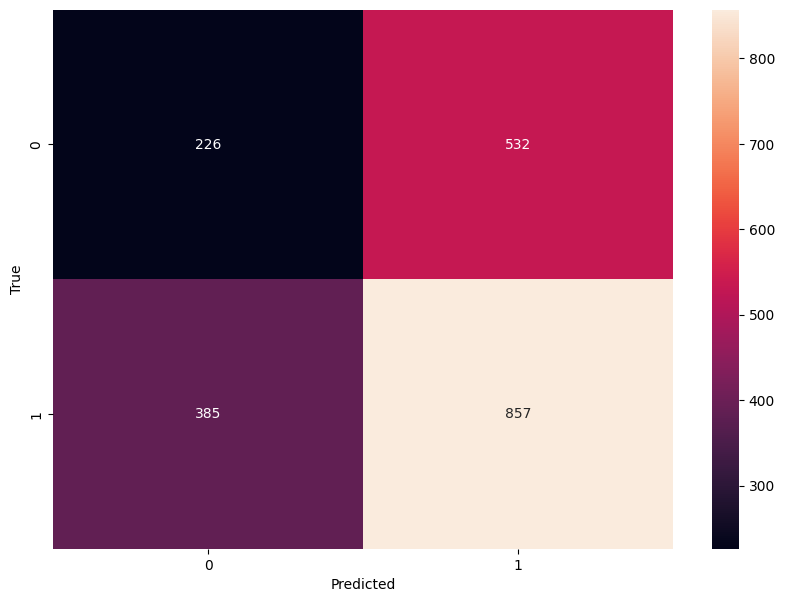

              precision    recall  f1-score   support

           0       0.37      0.30      0.33       758
           1       0.62      0.69      0.65      1242

    accuracy                           0.54      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.52      0.54      0.53      2000



In [43]:
# Optuna 스터디에서 최적의 하이퍼파라미터 가져오기
best_params = study.best_trial.params

# 최적의 하이퍼파라미터를 사용하여 CatBoost 모델 초기화
final_model = CatBoostClassifier(**best_params, verbose=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
# 전체 훈련 데이터셋을 사용하여 최종 모델 훈련
final_model.fit(x_train, y_train)

# 테스트 데이터셋에 대한 예측 수행
y_test_pred = final_model.predict(x_test)

# 혼동행렬
from sklearn.metrics import confusion_matrix
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_test_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 클래스별 성능 지표 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

In [44]:
cat_y_final_pred2 =final_model.predict(new_x)
cat_y_test_pred = y_test_pred
cat_y_test = y_test
cat_y_final_pred2

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
knn_y_val_pred
knn_y_val
knn_y_final_pred

In [ ]:
knn2_y_test_pred
knn2_y_test
knn_y_final_pred2

In [ ]:
cat_y_test_pred
cat_y_test
cat_y_final_pred2

In [47]:
print(knn_y_val.shape)
print(knn2_y_test.shape)
print(cat_y_test.shape)

(2000, 1)
(2000,)
(2000,)


In [66]:
knn_y_val = knn_y_val.reset_index(drop =True)

,target
0,1
1,0
2,1
3,1
4,1
...,...
1995,0
1996,1
1997,1
1998,0


In [67]:
x_train_final = pd.DataFrame(np.column_stack((knn_y_val_pred,knn2_y_test_pred,cat_y_test_pred)))
y_train_final = knn_y_val = knn_y_val.reset_index(drop =True)

In [77]:
x_test_final = pd.DataFrame(np.column_stack((knn_y_final_pred,knn_y_final_pred2,cat_y_final_pred2)))

# 최종 메타모델 KNN

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


Best parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Best cross-validation score: 0.51


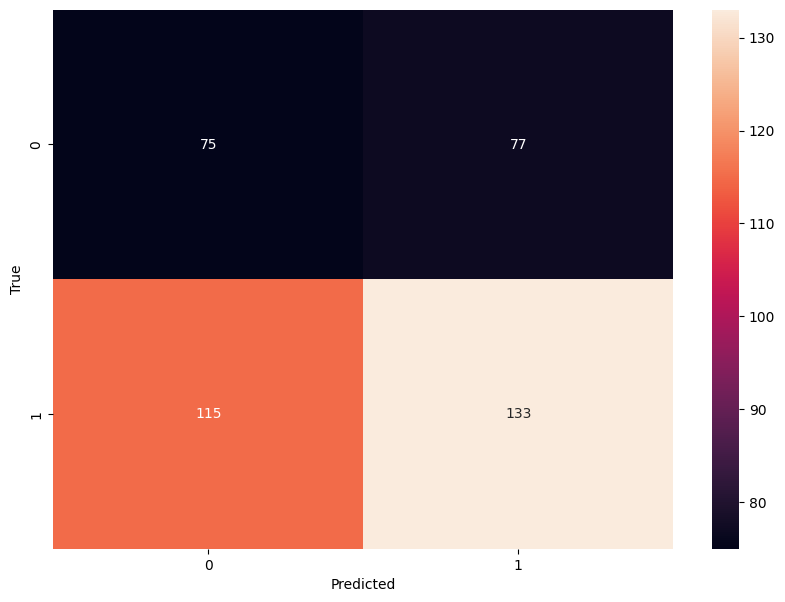

              precision    recall  f1-score   support

           0       0.39      0.49      0.44       152
           1       0.63      0.54      0.58       248

    accuracy                           0.52       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.54      0.52      0.53       400



In [75]:
x_train, x_val, y_train, y_val = train_test_split(x_train_final, y_train_final, test_size = 0.2,stratify=y_train_final, random_state = 42)


# 랜덤 시드 고정
np.random.seed(42)


# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

# KNN 모델 생성
knn = KNeighborsClassifier()

# GridSearchCV 객체 생성
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=1)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 파라미터와 점수 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# 최적 파라미터로 모델 학습
best_params = grid_search.best_params_
knn_model = KNeighborsClassifier(**best_params)

knn_model.fit(x_train, y_train)
y_val_pred = knn_model.predict(x_val)
f1_score(y_val, y_val_pred, average = 'macro')


#############################################################################
# 혼동행렬
from sklearn.metrics import confusion_matrix
# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 클래스별 성능 지표 출력
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

In [79]:
final_predictions = knn_model.predict(x_test_final)

In [83]:
final_predictions

array([0, 0, 1, ..., 1, 0, 1])

In [84]:
# 예측값 저장
df_sub['target'] = final_predictions
df_sub.set_index('user_id').to_csv('knn1_knn2_catboost_stacking.csv', encoding="cp949")